In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.utils import shuffle
%matplotlib inline

Columns in all data sets: 
* mjj (TeV)
* mjmin (TeV)
* mjmax-mjmin (TeV)
* tau21(mjmin) 
* tau21 (mjmax)
* sigorbg label

In [2]:
mock_sr_train = pd.read_csv("../../data/mock/SR_train.csv")
mock_sr_val = pd.read_csv("../../data/mock/SR_val.csv")
mock_sb_train = pd.read_csv("../../data/mock/SB_train.csv")
mock_sb_val = pd.read_csv("../../data/mock/SB_val.csv")

full_mock = pd.concat([mock_sr_train, mock_sr_val, mock_sb_train, mock_sb_val], axis=0)
sr_mock = pd.concat([mock_sr_train, mock_sr_val], axis=0)
full_mock.shape, full_mock.to_numpy()[:, -1].sum()

((998876, 6), 992.0)

In [3]:
LHCO_RD_dataset = pd.read_csv("../../data/full_LHCO_RnD.csv")
LHCO_RD_dataset['type'] = LHCO_RD_dataset['5'].map({0: "Background", 1: "Signal"})
LHCO_RD_dataset.shape, LHCO_RD_dataset.to_numpy()[:, 5].sum()

((1100000, 7), 100000.0)

In [4]:
def feature_hists(X, n_bins=30, highlight_SR=False):
    x_names = [r'$m_{jj}$ (TeV)', r'$m_{j1}$ (TeV)', r'$m_{j2}-m_{j1}$ (TeV)',
               r'$\tau_{21}^{j1}$', r'$\tau_{21}^{j2}$', 'Signal / Background, %']
    x_columns = X.columns
    X = X.copy()
    X['type'] = X['5'].map({0: "Background", 1: "Signal"})

    plt.figure(figsize=(5 * 3, 4 * 2))
    for i in range(X.shape[1] - 1):
        plt.subplot(2, 3, i + 1)
        bins = np.linspace(X[x_columns[i]].min(), X[x_columns[i]].max(), n_bins)
        stat = "density" if i != 5 else "percent"
        sns.histplot(data=X, x=x_columns[i], stat=stat, element="step", hue="type", bins=bins, linewidth=1)
        plt.xlabel(x_names[i], size=14)
        if i % 3 == 0:
            plt.ylabel('Density', size=14)
        elif i == 5:
            plt.ylabel('Percent', size=14)
        else:
            plt.ylabel(None)

        if i == 0 and highlight_SR:
            plt.axvline(3.3, linestyle="--", c="black", label="SR = [3.3; 3.7] TeV")
            plt.axvline(3.7, linestyle="--", c="black")
            plt.legend()
        plt.xticks(size=14)
        plt.yticks(size=14)
    plt.tight_layout()
    plt.show()

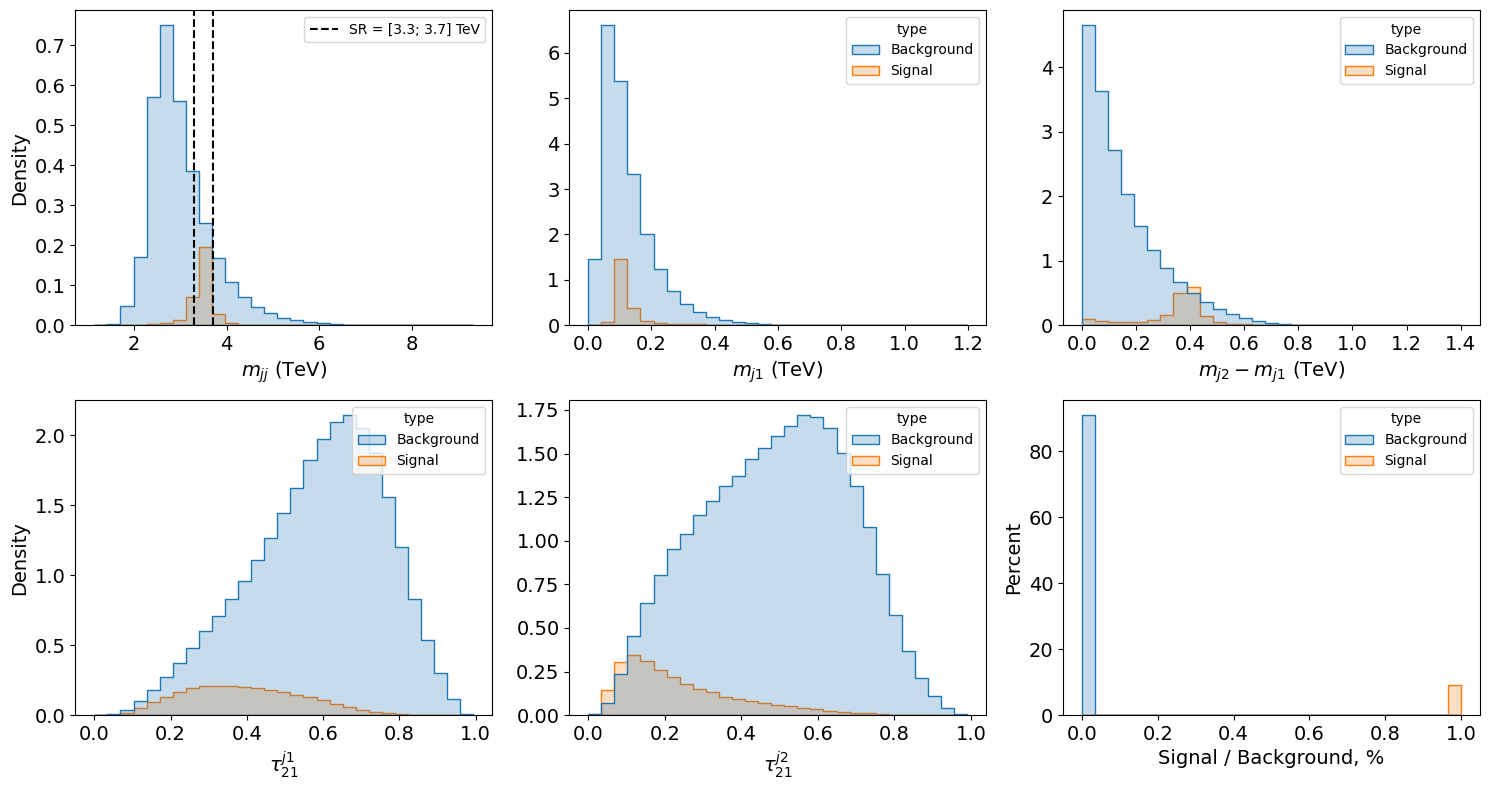

In [5]:
feature_hists(LHCO_RD_dataset, highlight_SR=True)

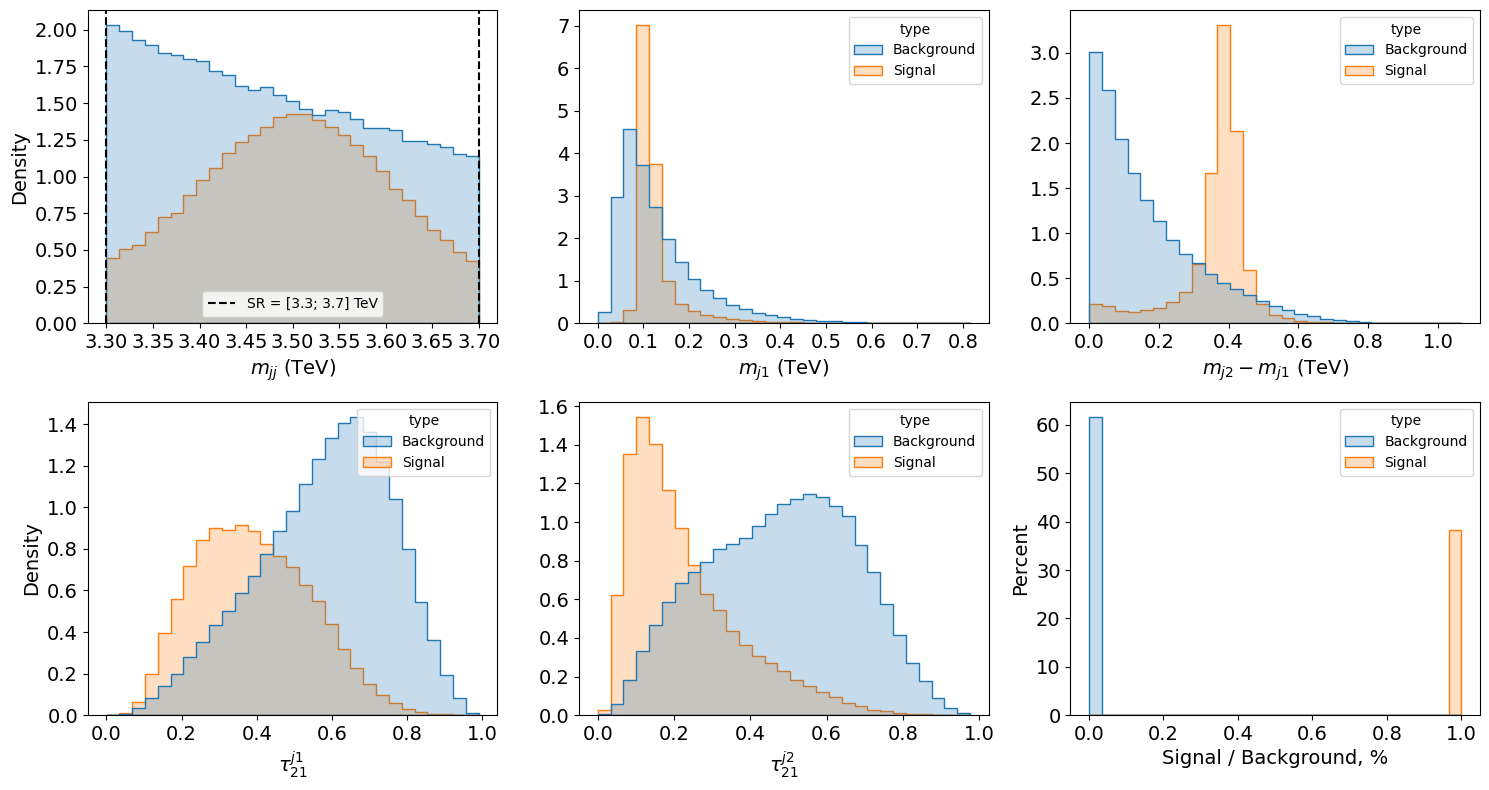

In [6]:
LHCO_SR = LHCO_RD_dataset.loc[LHCO_RD_dataset['0'].between(3.3, 3.7)]
feature_hists(LHCO_SR, highlight_SR=True)

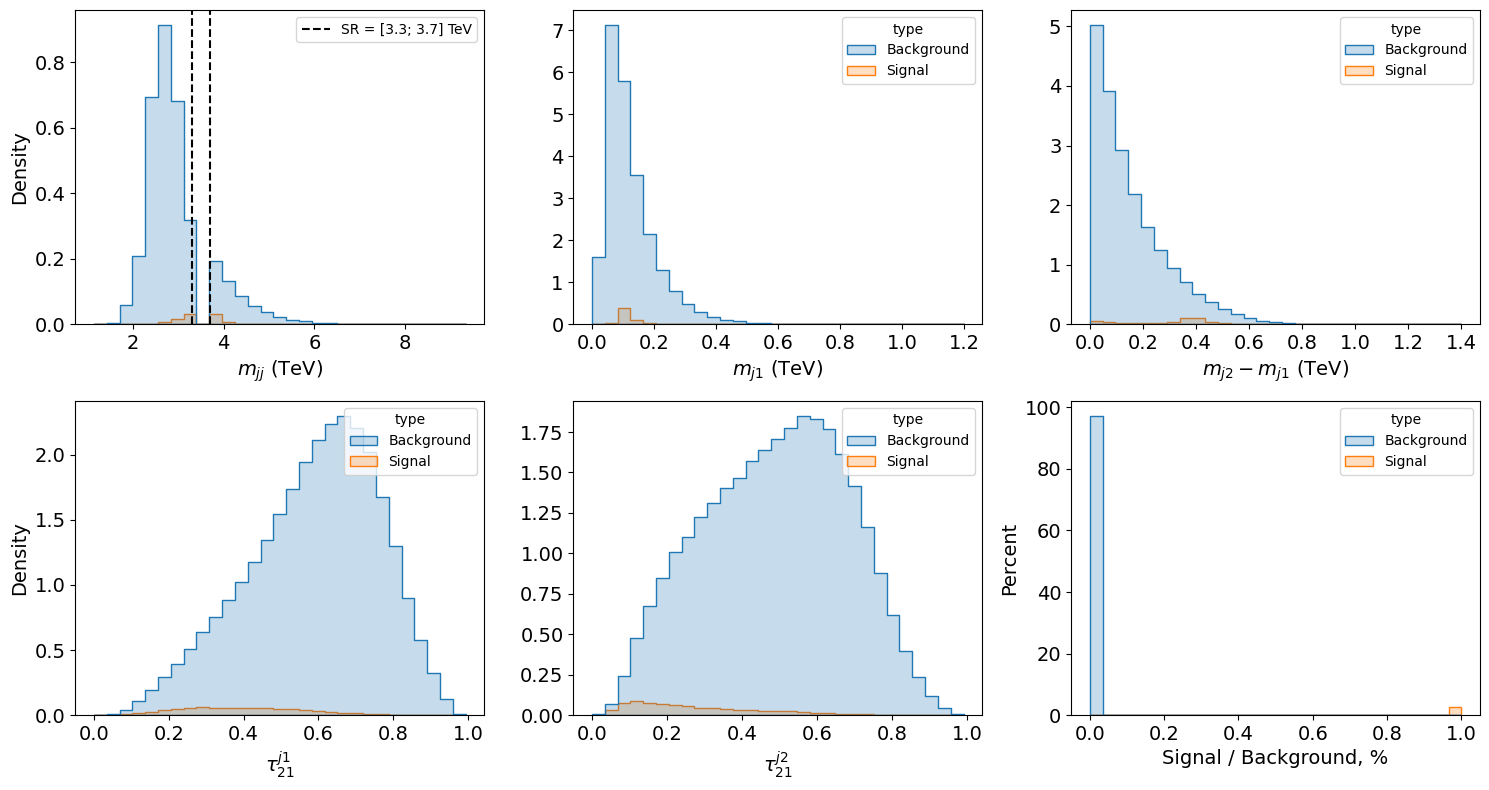

In [7]:
LHCO_SB = LHCO_RD_dataset.loc[(LHCO_RD_dataset['0'] < 3.3) | (LHCO_RD_dataset['0'] > 3.7)]
feature_hists(LHCO_SB, highlight_SR=True)

In [8]:
class Logiter(object):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.x_max = None
        self.x_min = None
        
    def fit(self, X, y=None):
        self.x_min = np.min(X, axis=0)
        self.x_max = np.max(X, axis=0)
        self.mean = None
        self.std = None
        return self

    def logit_transform(self, data):
        data2 = (data - self.x_min) / (self.x_max - self.x_min)
        mask = np.prod((data2 > 0) & (data2 < 1), axis=1).astype(bool)
    
        data3 = data2[mask]
        data4 = np.log((data3) / (1 - data3))
        
        no_infs_logit = np.ma.masked_invalid(data4)
        no_inf_max = no_infs_logit.max(axis=0).data
        no_inf_min = no_infs_logit.min(axis=0).data
        data4 = np.clip(data4, no_inf_min, no_inf_max)

        if self.mean is None:
            self.mean = np.mean(data4, axis=0)
        if self.std is None:
            self.std = np.std(data4, axis=0)
        return (data4 - self.mean) / self.std, mask

    def logit_transform_inverse(self, data):
        data1 = data * self.std + self.mean
        dataout = (self.x_min + self.x_max * np.exp(data1)) / (1 + np.exp(data1))
        return dataout
    
    
def quick_logit(x):
    x_norm = (x - min(x)) / (max(x) - min(x))
    x_norm = x_norm[(x_norm != 0) & (x_norm != 1)]
    logit = np.log(x_norm / (1 - x_norm))
    logit = logit[~np.isnan(logit)]
    return logit

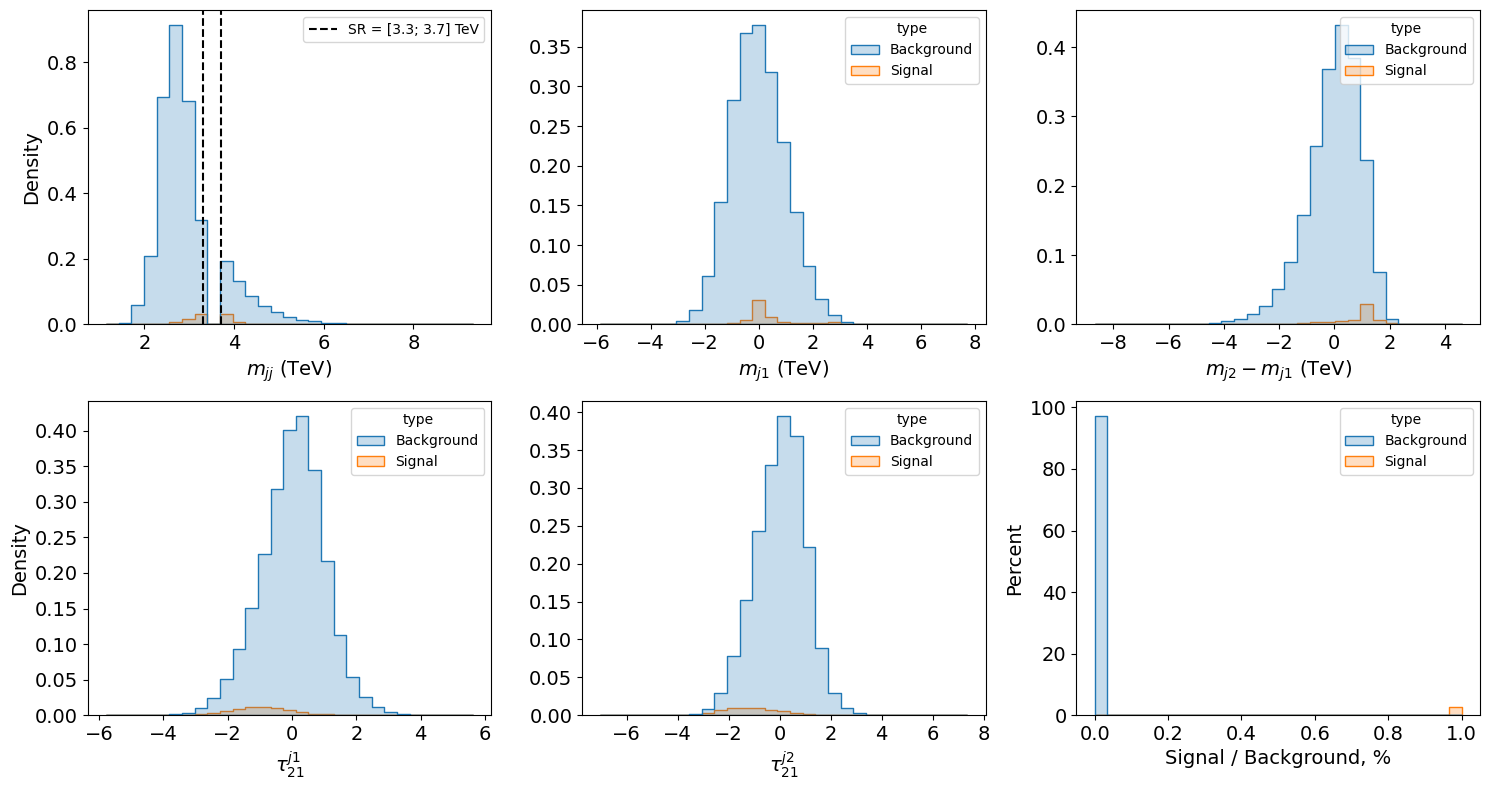

In [16]:
scaler = Logiter().fit(LHCO_SB[['1', '2', '3', '4']])

LHCO_SB_scaled = LHCO_SB.copy()
LHCO_SB_scaled[['1', '2', '3', '4']], mask = scaler.logit_transform(LHCO_SB_scaled[['1', '2', '3', '4']])
feature_hists(LHCO_SB_scaled.loc[mask], highlight_SR=True)

In [14]:
def feature_scatter2d(X):
    x_names = [r'$m_{jj}$ (TeV)', r'$m_{j1}$ (TeV)', r'$m_{j2}-m_{j1}$ (TeV)',
               r'$\tau_{21}^{j1}$', r'$\tau_{21}^{j2}$', 'Signal / Background, %']
    x_columns = X.columns
    X = X.copy()
    X['type'] = X['5'].map({0: "Background", 1: "Signal"})

    plt.figure(figsize=(5 * 5, 4 * 5))
    for i in range(X.shape[1] - 1):
        for j in range(X.shape[1] - 1):
            if j >= i: continue
            if i == 5 or j == 5: continue
            plt.subplot(5, 5, 5 * i + j + 1)
            sns.scatterplot(data=X, x=x_columns[i], y=x_columns[j], hue="type")
            plt.xlabel(x_names[i], size=14)
            plt.ylabel(x_names[j], size=14)
            plt.xticks(size=14)
            plt.yticks(size=14)
    # plt.legend()
    plt.tight_layout()
    plt.show()

c:\users\oleg\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


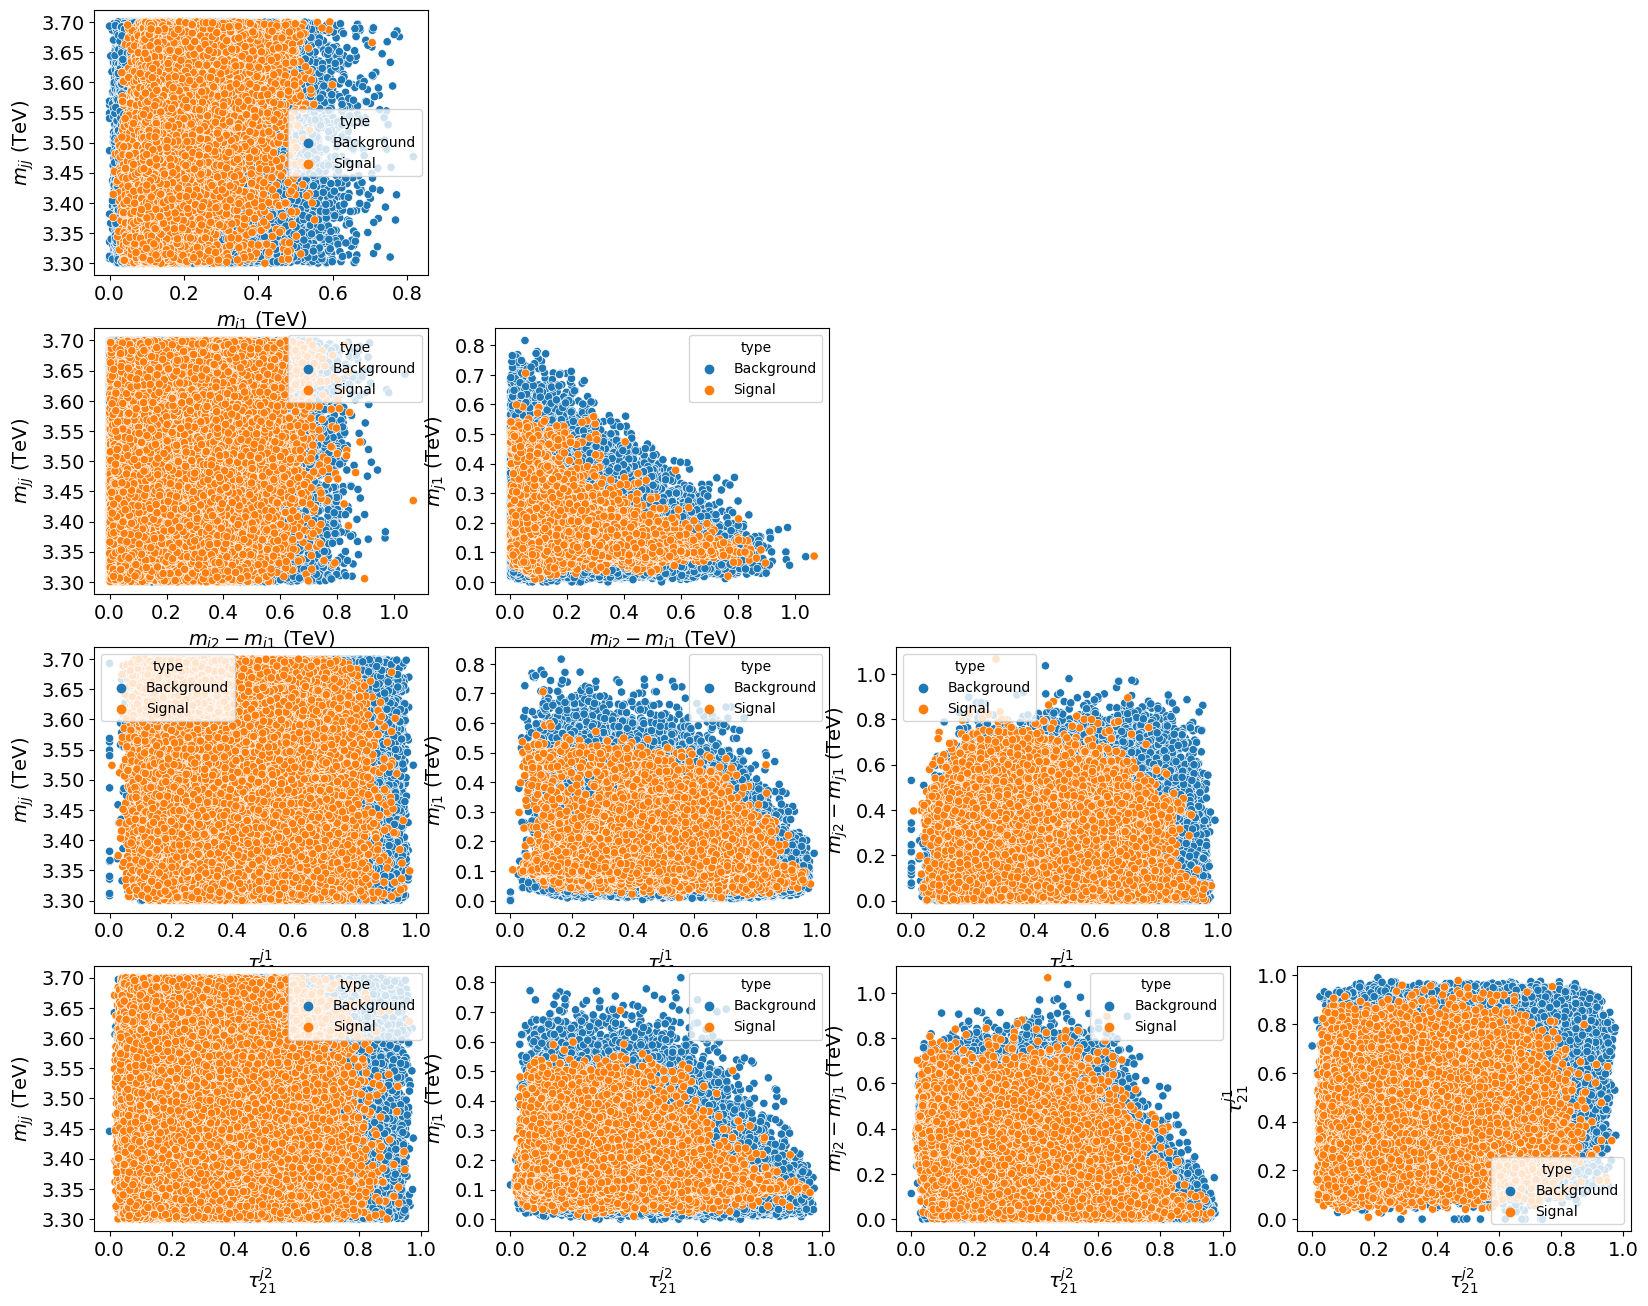

In [7]:
LHCO_SR = LHCO_RD_dataset.loc[LHCO_RD_dataset['0'].between(3.3, 3.7)]
feature_scatter2d(LHCO_SR)

In [9]:
LHCO_SR['5'].sum() / LHCO_RD_dataset['5'].sum() * 100

75.299